In [1]:
import os
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential
import matplotlib.pyplot as plt

In [2]:
# Check if GPU (cuda) is available, otherwise use CPU
device = tf.config.list_physical_devices('GPU')
print(device)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-11-12 17:09:28.658526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-12 17:09:28.770606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-12 17:09:28.770667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
# MLFlow setup
import mlflow
import keras_tuner

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("SPT model")

<Experiment: artifact_location='mlflow-artifacts:/174269503646235714', creation_time=1699805301075, experiment_id='174269503646235714', last_update_time=1699805301075, lifecycle_stage='active', name='SPT model', tags={}>

In [4]:
l = 300
valid_idx = 4
print('The validation fold is {}'.format(valid_idx))  # Print the validation fold index

The validation fold is 4


In [5]:
# Create a model path based on 'l' and 'valid_idx'
model_path = './models/Fold{}/{}/'.format(valid_idx, l)
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [6]:
from data_management import get_data_generator_and_tests

train_generator, test_x, test_y = get_data_generator_and_tests(l, valid_idx)

Train data:  (120000, 300) (120000,)
Test data:  (30000, 300) (30000,)


In [7]:
from keras import optimizers, losses

def build_model(lstm_amount, lstm_deepness, dense_amount, dense_deepness, lr, dropout):
    '''
    This function returns compiled keras LSTM model with the parameters provided.
    lstm_amount: int - amount of LSTM layers in the model
    lstm_deepness: int - deepness of the LSTM layers above
    dense_amount: int - amount of dense layers that follow the LSTM layers
    dense_deepness: int - deepness of the dense layers above
    lr: float - learning rate for Adam optimizer
    dropout: float - dropout percentage after the first LSTM layer
    '''
    model = Sequential()
    model.add(layers.LSTM(lstm_deepness, input_shape=(None, 1), return_sequences=True))
    model.add(layers.Dropout(dropout))

    if lstm_amount != 0:
        for i in range(0, lstm_amount-1):
            model.add(layers.LSTM(lstm_deepness, return_sequences=True))
        model.add(layers.LSTM(lstm_deepness))

    for i in range(0, dense_amount):
        model.add(layers.Dense(dense_deepness))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizers.Adam(learning_rate=lr), loss=losses.MSE, metrics=['MAE'])
    return model

In [8]:
from keras_tuner import HyperParameters, BayesianOptimization

# Create a HyperModel subclass for MLFlow tracking
class SGNNHyperModel(keras_tuner.HyperModel):

    def build(self, hp):
        # Create your model, set some hyper-parameters here
        model = build_model(
            hp.Choice('lstm_amount', [0, 1, 2, 3, 4]),
            hp.Choice('lstm_deepness', [32, 64, 128]),
            hp.Choice('dense_amount', [0, 1, 2, 3]),
            hp.Choice('dense_deepness', [32, 64, 128]),
            hp.Choice('lr', [0.1, 0.01, 0.001]),
            hp.Choice('dropout', [0.0, 0.2, 0.4, 0.6])
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        with mlflow.start_run():
            mlflow.log_params(hp.values)
            mlflow.tensorflow.autolog()
            return model.fit(*args, **kwargs)

In [ ]:
# Start hyperparameter optimization
tuner = BayesianOptimization(
    SGNNHyperModel(),
    max_trials=20,
    # Do not resume the previous search in the same directory.
    overwrite=True,
    objective="MAE",
    # Set a directory to store the intermediate results.
    directory="./tmp/tb",
)

tuner.search(train_generator, epochs=30, validation_data=(test_x, test_y))

best_model = tuner.get_best_models()[0]
best_hyperparameters= tuner.get_best_hyperparameters()[0].values

In [12]:
model = build_model(1, 64, 0, 64, 0.001, 0.2)

# Train model manually
history = model.fit(train_generator, 
                    # batch_size=128,
                    # validation_split=0.2,
                    epochs=25,
                    validation_data=(test_x, test_y)
                    )

2023/11/12 17:18:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e488cac5a09c4aebb0a2ce5cdc43fcf6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2023/11/12 17:18:27 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'data_management.DataGenerator'>. Dataset logging skipped.


Epoch 1/25
468/468 [==============================] - 51s 103ms/step - loss: 0.2780 - MAE: 0.4330 - val_loss: 0.2410 - val_MAE: 0.4061
Epoch 2/25
468/468 [==============================] - 47s 100ms/step - loss: 0.2391 - MAE: 0.3975 - val_loss: 0.2420 - val_MAE: 0.3978
Epoch 3/25
468/468 [==============================] - 47s 101ms/step - loss: 0.2355 - MAE: 0.3927 - val_loss: 0.2250 - val_MAE: 0.3866
Epoch 4/25
468/468 [==============================] - 47s 100ms/step - loss: 0.2266 - MAE: 0.3824 - val_loss: 0.2258 - val_MAE: 0.3810
Epoch 5/25
468/468 [==============================] - 45s 96ms/step - loss: 0.2235 - MAE: 0.3784 - val_loss: 0.2159 - val_MAE: 0.3692
Epoch 6/25
468/468 [==============================] - 45s 96ms/step - loss: 0.2303 - MAE: 0.3848 - val_loss: 0.2619 - val_MAE: 0.4183
Epoch 7/25
468/468 [==============================] - 43s 93ms/step - loss: 0.2320 - MAE: 0.3888 - val_loss: 0.2225 - val_MAE: 0.3762
Epoch 8/25
468/468 [==============================] - 43s 

INFO:tensorflow:Assets written to: /tmp/tmp3_is2xvj/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp3_is2xvj/model/data/model/assets


In [13]:
model.save_weights(model_path+'spt_model.h5')

In [14]:
preds = model.predict(test_x)

938/938 [==============================] - 22s 23ms/step


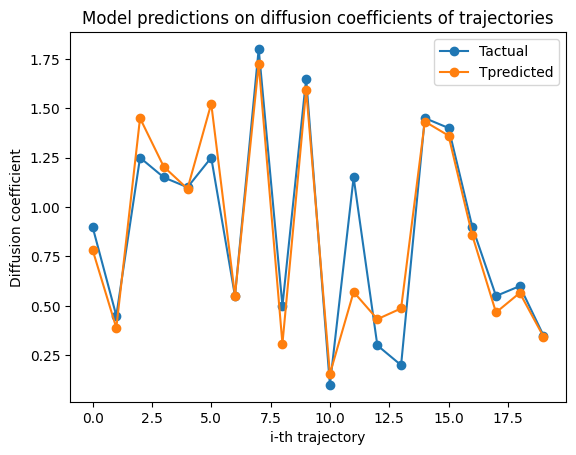

In [16]:
plt.clf()
plt.plot(range(0, 20), test_y[:20], 'o-', label='Tactual')
plt.plot(range(0, 20), preds[:20], 'o-', label='Tpredicted')
plt.legend()
plt.ylabel("Diffusion coefficient")
plt.xlabel("i-th trajectory")
plt.title("Model predictions on diffusion coefficients of trajectories")
plt.show()